# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import mglearn

# Datasets

In [2]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
dfraw = pd.DataFrame(cancer['data'], columns=cancer['feature_names'])
dfraw = dfraw.loc[:, 'mean radius':'mean perimeter']  # use only first 3 features for simplicity

In [3]:
# add a categorical 'state' column (example: random assignment from a small set)
states = ['NY', 'CA', 'TX', 'FL', 'IL']
np.random.seed(0)
dfraw['state'] = pd.Categorical(np.random.choice(states, size=len(dfraw)))

product = ['a', 'b', 'c']
dfraw['product'] = pd.Categorical(np.random.choice(product, size=len(dfraw)))

In [4]:
dfraw['target'] = cancer['target']
# convert numeric target to categorical labels
dfraw['target'] = pd.Categorical(dfraw['target'])

dfraw

,mean radius,mean texture,mean perimeter,state,product,target
0,17.99,10.38,122.80,IL,b,0
1,20.57,17.77,132.90,NY,c,0
2,19.69,21.25,130.00,FL,a,0
3,11.42,20.38,77.58,FL,b,0
4,20.29,14.34,135.10,FL,a,0
...,...,...,...,...,...,...
564,21.56,22.39,142.00,FL,c,0
565,20.13,28.25,131.20,TX,a,0
566,16.60,28.08,108.30,TX,a,0
567,20.60,29.33,140.10,IL,b,0


# Data Partitioning

In [5]:
from sklearn.model_selection import train_test_split

dftemp=dfraw.drop(columns='target',inplace=False)
X_train, X_test, y_train, y_test = train_test_split(
    dftemp, dfraw['target'], stratify=cancer.target, random_state=42)

dftrain=pd.concat([X_train, y_train], axis=1)
dftrain['traintest']= 'train'

dftest=pd.concat([X_test, y_test], axis=1)
dftest['traintest']= 'test'

dfall = pd.concat([dftrain, dftest], axis=0)

# EDA (Exploratory Data Analysis)

## Overall Analysis

In [6]:
# build dataframe summary with missing counts & percentages
dfsummary = pd.DataFrame({
    'Variable': dftrain.columns,
    'DataType': dftrain.dtypes.astype(str),
    'total_count': len(dftrain),
    'non_null_count': dftrain.notnull().sum().values,
    'missing_count': dftrain.isnull().sum().values,
    'missing_pct': (dftrain.isnull().mean() * 100).round(2).values,
    'n_unique': dftrain.nunique().values
})

# optional: include up to 3 sample values per column
dfsummary['samples'] = dftrain.apply(lambda s: s.dropna().unique()[:3].tolist()).values

dfsummary

,Variable,DataType,total_count,non_null_count,missing_count,missing_pct,n_unique,samples
mean radius,mean radius,float64,426,426,0,0.0,356,"[19.89, 12.89, 17.14]"
mean texture,mean texture,float64,426,426,0,0.0,373,"[20.26, 13.12, 16.4]"
mean perimeter,mean perimeter,float64,426,426,0,0.0,399,"[130.5, 81.89, 116.0]"
state,state,category,426,426,0,0.0,5,"[TX, NY, FL]"
product,product,category,426,426,0,0.0,3,"[c, a, b]"
target,target,category,426,426,0,0.0,2,"[0, 1]"
traintest,traintest,object,426,426,0,0.0,1,[train]


## Continuous-Continuous

In [7]:
dftrain.describe()

,mean radius,mean texture,mean perimeter
count,426.000000,426.000000,426.000000
mean,14.075202,19.295047,91.592911
std,3.508920,4.447806,24.184996
min,6.981000,9.710000,43.790000
25%,11.632500,15.990000,74.720000
50%,13.275000,18.825000,86.040000
75%,15.745000,21.795000,103.675000
max,28.110000,39.280000,188.500000


Text(0.5, 1.02, 'Pairplot with Correlation in Upper Triangle')

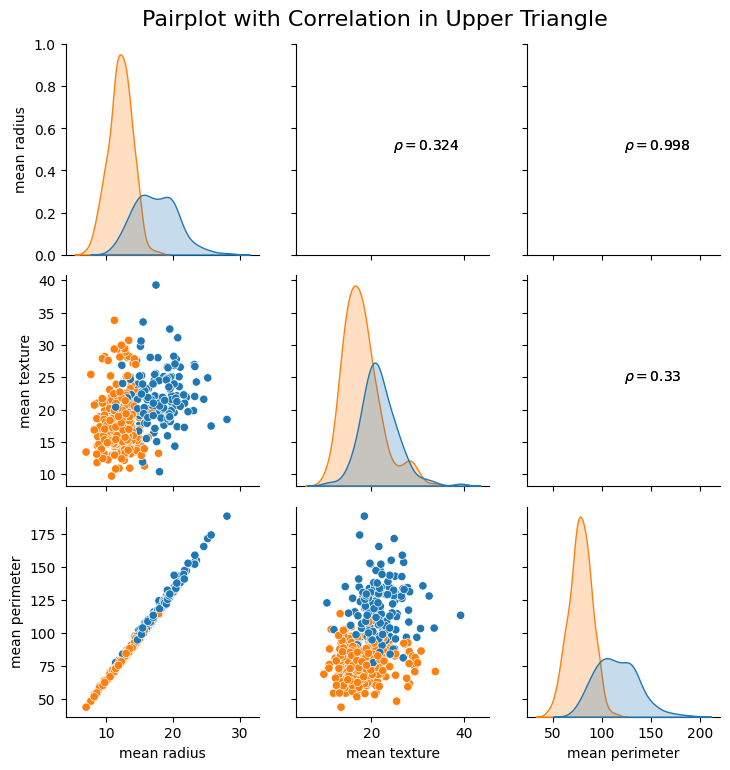

In [8]:
g = sns.PairGrid(dftrain, hue='target',diag_sharey=False)

def corrfunc(x, y, **kws):
    # r = np.corrcoef(x, y)[0][1]
    # dftemp=pd.DataFrame(data={'x':x, 'y':y})
    # r = dftemp.corr().round(3).iloc[0,1]
    
    r = dfraw[[x.name, y.name]].corr().iloc[0, 1].round(3)

    ax = plt.gca()
    # ax.clear()
    # ax.spines['left'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)
    # ax.set_xticks([])
    # ax.set_yticks([])
    ax.text(.5,.5,f"$\\rho = {r}$",transform=ax.transAxes)

g.map_upper(corrfunc) 
g.map_diag(sns.kdeplot, fill=True)
g.map_lower(sns.scatterplot)

# Add title
g.fig.suptitle('Pairplot with Correlation in Upper Triangle', fontsize=16, y=1.02)

## Categorical-Categorical

In [12]:
dfcat

['state', 'product', 'target', 'traintest']

<>:30: SyntaxWarning: invalid escape sequence '\c'
<>:30: SyntaxWarning: invalid escape sequence '\c'
C:\Users\ChaudharyVimal\AppData\Local\Temp\ipykernel_33668\1122937619.py:30: SyntaxWarning: invalid escape sequence '\c'
  axs[i,j].text(.4,.4,f"$\chi^2 = {chi2:.2f}$" + "\n" f"p-value = {p:.2f}" + "\n" f"df = {dof:.2f}",


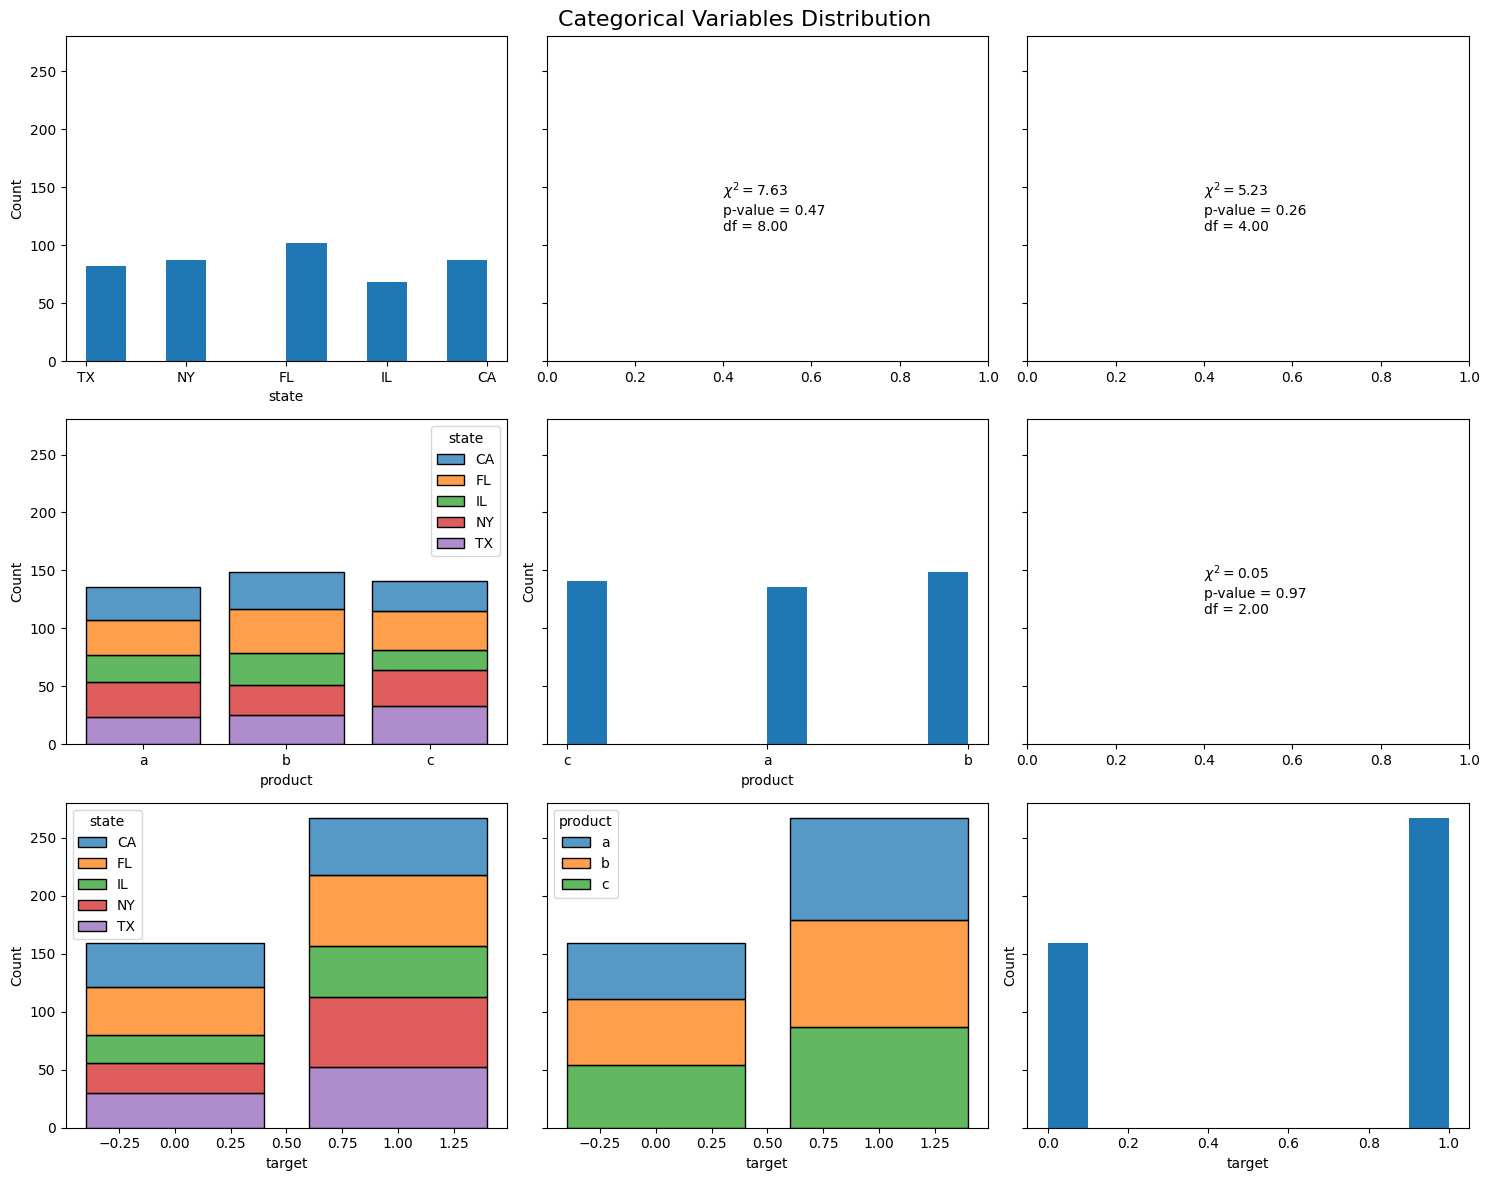

In [13]:
dfcat = dftrain.select_dtypes(include=['object', 'category']).columns.tolist()
dfcat = ['state', 'product', 'target']

#dfcat = dfsummary[dfsummary['DataType'].isin(['category'])]

fig, axs = plt.subplots(nrows=len(dfcat),ncols = len(dfcat), figsize=(5*len(dfcat),4*len(dfcat)),sharey=True)
for i, col in enumerate(dfcat):
    for j in range(len(dfcat)):
        if i==j:
            axs[i,j].hist(data=dftrain[dfcat], x=col)
            # sns.histplot(data=df, x=col, multiple='stack', stat='proportion')
            axs[i,j].set_xlabel(col)
            axs[i,j].set_ylabel('Count')
        elif i>j:
            # axs[i,j].hist(data=df[dfcat], x=col, stacked=True)
            sns.histplot(
                data=dftrain,
                x=col,
                hue=dfcat[j],            # stack by this categorical column
                multiple="stack",
                stat="count",
                shrink=0.8,
                ax=axs[i, j]
            )
            axs[i,j].set_xlabel(col)
            axs[i,j].set_ylabel('Count')
        elif i<j:
            contingency_table = pd.crosstab(dfraw[col], dfraw[dfcat[j]])
            chi2, p, dof, expected = chi2_contingency(contingency_table)
            axs[i,j].text(.4,.4,f"$\chi^2 = {chi2:.2f}$" + "\n" f"p-value = {p:.2f}" + "\n" f"df = {dof:.2f}",
            transform=axs[i,j].transAxes)


fig.suptitle('Categorical Variables Distribution', fontsize=16)
plt.tight_layout()

## Continuous-Categorical

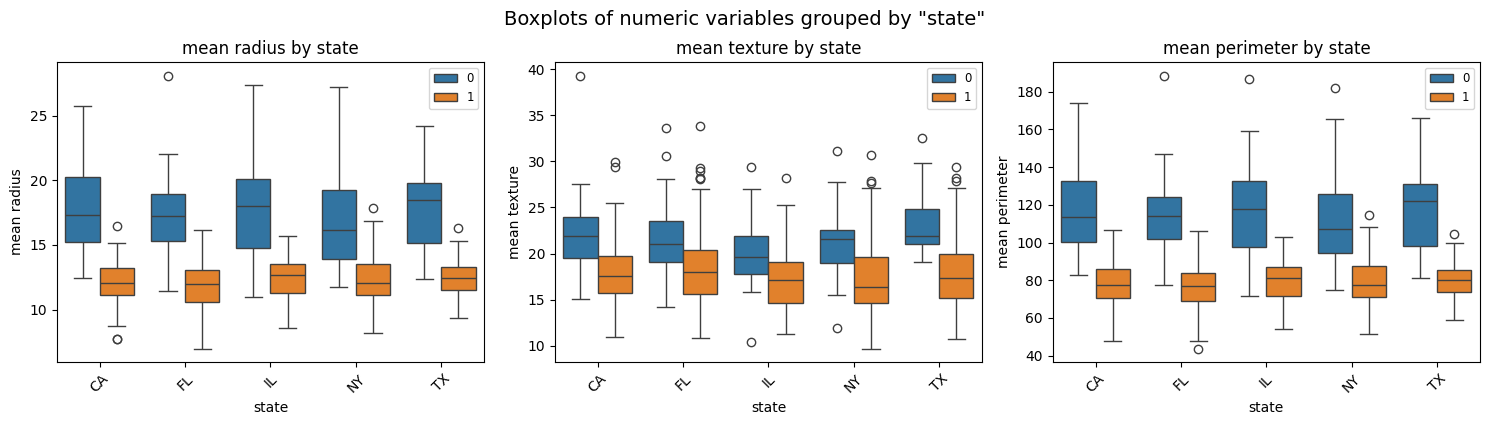

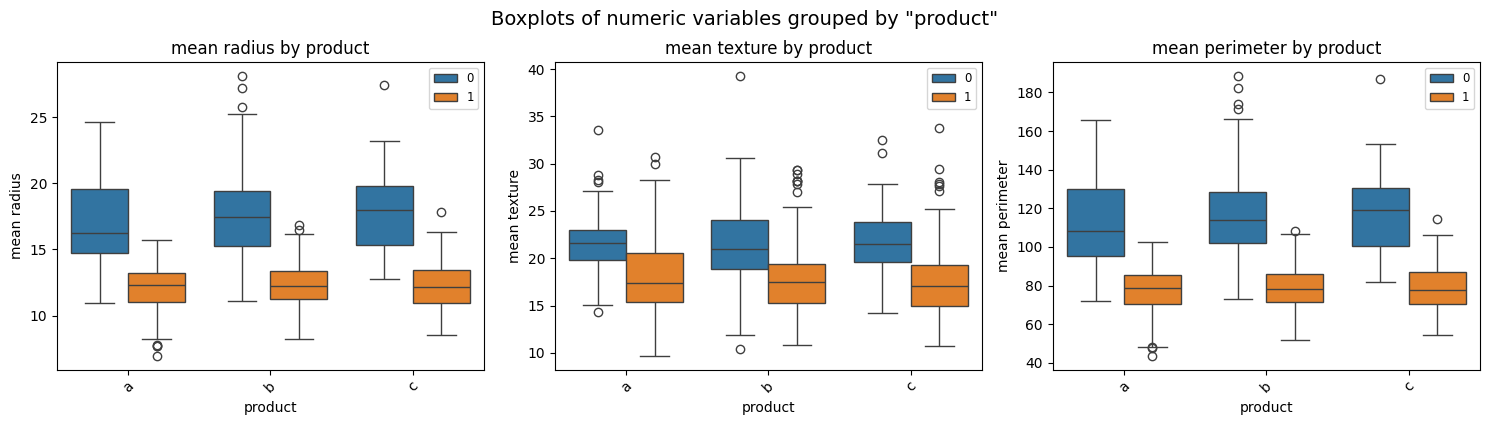

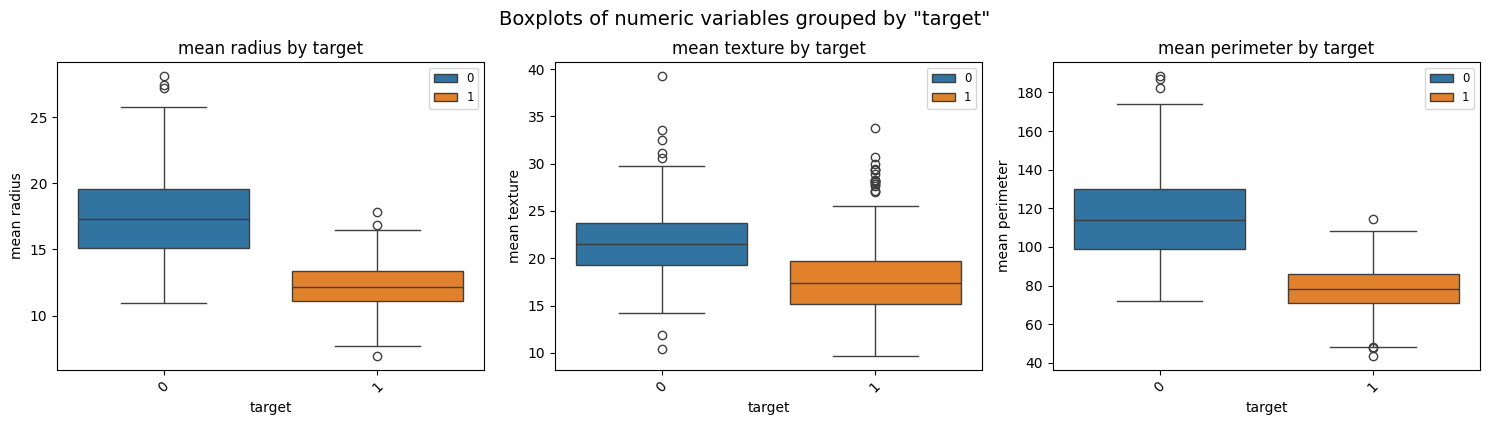

In [14]:
import math

dfnum = dftrain.select_dtypes(include=['number']).columns.tolist()
# cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

if len(dfnum) == 0 or len(dfcat) == 0:
    print("Need at least one numeric and one categorical column.")
else:
    for cat in dfcat:
        n = len(dfnum)
        ncols = 3
        nrows = math.ceil(n / ncols)
        fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows), squeeze=False)
        axs_flat = axs.flatten()

        for i, num in enumerate(dfnum):
            ax = axs_flat[i]
            if 'target' in dfraw.columns:
                sns.boxplot(data=dfraw, x=cat, y=num, hue='target', ax=ax)
                ax.legend(loc='upper right', fontsize='small')
            else:
                sns.boxplot(data=dfraw, x=cat, y=num, ax=ax)
            ax.set_title(f"{num} by {cat}")
            ax.tick_params(axis='x', rotation=45)

        # turn off any unused subplots
        for j in range(n, len(axs_flat)):
            axs_flat[j].axis('off')

        fig.suptitle(f'Boxplots of numeric variables grouped by "{cat}"', fontsize=14, y=1.05)
        plt.tight_layout()
        fig.subplots_adjust(top=0.92)


# Preprocessing

## Feature Engineering

### Binning

In [ ]:
# KBinsDiscretizer
bins = np.linspace(43, 190, 5)
print("bins: {}".format(bins))

dfall['mean perimeter_binned'] = pd.cut(dfall['mean perimeter'], bins=bins, include_lowest=True)
dfall


### Dummy Variables, One-hot encoding

In [ ]:
dfall_dummy = pd.get_dummies(dfall, columns=['mean perimeter_binned','state', 'product','target'], drop_first=True)
dfall_dummy

In [ ]:
from sklearn.preprocessing import OneHotEncoder

cat_variables = ['mean perimeter_binned','state', 'product', 'target']

enc = OneHotEncoder(drop='first')
enc.fit(dfall.loc[dfall['traintest'] == 'train',cat_variables])

df_encoded = enc.transform(dfall[cat_variables])
df_encoded = pd.DataFrame(df_encoded.toarray(), columns=enc.get_feature_names_out(cat_variables))
dfall_encoded = dfall.drop(columns=cat_variables).reset_index(drop=True).join(df_encoded)
dfall_encoded



### Interactions and Polynomials

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

num_variables = ['mean perimeter', 'mean texture']

poly = PolynomialFeatures(degree=2, include_bias=False,interaction_only=True)
poly.fit(dfall.loc[dfall['traintest'] == 'train',num_variables])

df_poly = poly.transform(dfall[num_variables])
df_poly = pd.DataFrame(df_poly, columns=poly.get_feature_names_out(num_variables))
dfall_poly = dfall.drop(columns=num_variables).reset_index(drop=True).join(df_poly)
dfall_poly

### Univariate non-linear transformation

In [ ]:
# exp, log


## Scaling

In [ ]:
# StandardScaler - z = (x - u) / s (transformed data has µ=0, σ =1)
# RobustScaler   - x_trans = (x - x_median) / IQR
# MinMaxScaler   - x_trans = (x - min) / (max-min)
# Normalizer     - rescales so Euclidean length =1, useful when angle (direction) is imp and not length (magnitude)?


from sklearn.preprocessing import MinMaxScaler

scale_variables = ['mean perimeter', 'mean texture']

scaler = MinMaxScaler()
scaler.fit(dfall.loc[dfall['traintest'] == 'train',num_variables])

df_scale = scaler.transform(dfall[num_variables])
df_scale = pd.DataFrame(df_scale, columns=scaler.get_feature_names_out(num_variables))
dfall_scale = dfall.drop(columns=num_variables).reset_index(drop=True).join(df_scale)

dfall_scale[scale_variables].describe()


## Missing Value Treatment

In [ ]:
# Drop columns with >5% missing values
cols_to_drop = dfsummary.loc[dfsummary['missing_pct']>.05,"Variable"].to_list()
dftrainmv = dftrain.drop(columns=cols_to_drop)
dftrainmv

In [ ]:
# Impute columns wuth <5% missing values

# num columns
dfnum = dftrainmv.select_dtypes(include=['number']).columns.tolist()
for i, var in enumerate(dfnum):
    dftrainmv[var].fillna(dftrainmv[var].mean(), inplace=True) 

# cat columns
dfcat = dftrainmv.select_dtypes(include=['object', 'category']).columns.tolist()
for i, var in enumerate(dfnum):
    dftrainmv[var].fillna(dftrainmv[var].mode()[0], inplace=True)

dftrainmv

## Outlier Treatment

# Feature Selection

## Correlation

In [ ]:
dfnum = dftrain.select_dtypes(include=['number'])
dfcorr = dfnum.corr().round(3)
dfcorr

In [ ]:
dfhicorr = dfcorr[(dfcorr.abs() > 0.7) & (dfcorr.abs() < 1)]
dfhicorr = dfhicorr.dropna(how='all').dropna(axis=1, how='all')
dfhicorr

## VIF

In [ ]:
# VIF Calculation using sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def calculate_vif_sklearn(df):
    # Select numeric columns
    dfnum = df.select_dtypes(include=['number'])
    
    vif_data = []
    for i in range(dfnum.shape[1]):
        y = dfnum.iloc[:, i]
        X = dfnum.drop(dfnum.columns[i], axis=1)
        
        # Fit linear regression
        model = LinearRegression()
        model.fit(X, y)
        
        # Compute R²
        r2 = model.score(X, y)
        
        # Compute VIF
        vif = 1 / (1 - r2) if r2 < 1 else float('inf')
        vif_data.append((dfnum.columns[i], vif))
    
    return pd.DataFrame(vif_data, columns=['feature', 'VIF'])

dftrainvif = calculate_vif_sklearn(dftrainmv)
dftrainvif

In [ ]:
# Drop columns with high VIF
def drop_high_vif(df, threshold=10):
    # dftemp=df.copy()

    
    while True:
        dfnum = df.select_dtypes(include=['number'])
        dfvif = calculate_vif_sklearn(dfnum)
        max_vif = dfvif['VIF'].max()
        if max_vif <= threshold:
            break
        drop_col = dfvif.loc[dfvif['VIF'].idxmax(), 'feature']
        print(f"Dropping column '{drop_col}' with VIF={max_vif:.2f}")
        df = df.drop(columns=[drop_col])
    return df, dfvif

dftrainvif, dffinalvif = drop_high_vif(dftrainmv, threshold=10)

In [ ]:
dftrainvif

## IV

In [ ]:
# IV Calculation
def calculate_iv(df, target, bins=10):
    iv_dict = {}
    for col in df.columns:
        if col == target:
            continue
        # Handle numeric vs categorical
        if pd.api.types.is_numeric_dtype(df[col]):
            binned= pd.qcut(df[col], bins, duplicates='drop')
            groups = df.groupby(binned,observed=True)
        else:
            groups = df.groupby(col,observed=True)
        
        # Calculate WOE and IV
        iv = 0
        for grp, subset in groups:
            good = (subset[target] == 0).sum()
            bad = (subset[target] == 1).sum()
            total_good = (df[target] == 0).sum()
            total_bad = (df[target] == 1).sum()
            
            if good == 0 or bad == 0:
                continue  # Avoid division by zero
            
            dist_good = good / total_good
            dist_bad = bad / total_bad
            woe = np.log(dist_good / dist_bad)
            iv += (dist_good - dist_bad) * woe
        
        iv_dict[col] = iv
        # df = df.drop(columns=[col+'_bin'], inplace=True, errors='ignore')
        
    return pd.DataFrame(list(iv_dict.items()), columns=['feature', 'IV']).sort_values(by='IV', ascending=False)

dftrainiv = calculate_iv(dftrainvif, target='target')
dftrainiv


In [ ]:
# Drop columns with IV < threshold
def drop_low_iv(df, target, threshold=0.02, bins=10):
    iv_df = calculate_iv(df, target, bins)
    low_iv_cols = iv_df[iv_df['IV'] < threshold]['feature'].tolist()
    
    print(f"Dropping columns with IV < {threshold}: {low_iv_cols}")
    
    df.drop(columns=low_iv_cols, inplace=True)
    return df, iv_df


dftrainiv, iv_table = drop_low_iv(dftrainvif, target='target', threshold=0.02)
dftrainiv


## Univariate Stats

In [ ]:
# Univariate stats e.g. Anova

# Tests - f_classif, f_regression
# Methods - SelectKBest, SelectPercentile

from sklearn.feature_selection import SelectPercentile, f_classif

drop_variables = ['target_1','traintest']

select = SelectPercentile(percentile=50)
select.fit(dfall_encoded.loc[dfall_encoded['traintest']== 'train',~dfall_encoded.columns.isin(drop_variables)],
 y_train)

df_select = select.transform(dfall_encoded.loc[:, ~dfall_encoded.columns.isin(drop_variables)])
df_select = pd.DataFrame(df_select, columns=select.get_feature_names_out())
dfall_select = pd.concat([df_select, dfall_encoded[['target_1','traintest']]],axis=1)

print(select.get_feature_names_out())
dfall_select


## Model Based Feature Selection

In [ ]:
# Unlike univariate selection, all features are considered to capture interactions
# 1) Linear Models - Ridge model can be used to feature selection (coef >0)
# 2) Tree Models    - feature_importances_

from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

drop_variables = ['target_1','traintest']

select = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42),
threshold="median")

select.fit(dfall_encoded.loc[dfall_encoded['traintest']== 'train',~dfall_encoded.columns.isin(drop_variables)],
 dfall_encoded.loc[dfall_encoded['traintest']== 'train','target_1'])

df_select = select.transform(dfall_encoded.loc[:, ~dfall_encoded.columns.isin(drop_variables)])
df_select = pd.DataFrame(dfall_select, columns=select.get_feature_names_out())
dfall_select = pd.concat([df_select, dfall_encoded[['target_1','traintest']]],axis=1)

dfall_select



## Recursive feature elimination (RFE)

In [ ]:
from sklearn.feature_selection import RFE

drop_variables = ['target_1','traintest']

select = RFE(RandomForestClassifier(n_estimators=100, random_state=42),n_features_to_select=3)
select.fit(dfall_encoded.loc[dfall_encoded['traintest']== 'train',~dfall_encoded.columns.isin(drop_variables)],
 dfall_encoded.loc[dfall_encoded['traintest']== 'train','target_1'])

df_select = select.transform(dfall_encoded.loc[:, ~dfall_encoded.columns.isin(drop_variables)])
df_select = pd.DataFrame(dfall_select, columns=select.get_feature_names_out())
dfall_select = pd.concat([df_select, dfall_encoded[['target_1','traintest']]],axis=1)

dfall_select
 

# Models

## kNN

In [ ]:
X_train = dftrainiv.drop(columns='target').select_dtypes(include=['number'])
X_test = X_test[X_train.columns]  # ensure test set has same features as train set
y_train = dftrainiv['target']

print("X_train shape is {}".format(X_train.shape))
print("X_test shape is {}".format(X_test.shape))
print("y_train shape is {}".format(y_train.shape))


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

ypred = knn.predict_proba(X_test)
print("ypred shape is {}".format(ypred.shape))
ypred[0:9,:]

print("Test set score: {:.2f}".format(knn.score(X_test, y_test)))

In [ ]:
from sklearn.inspection import DecisionBoundaryDisplay

fig, axes = plt.subplots(1, 3, figsize=(10, 3))

for n_neighbors, ax in zip([1, 3, 9], axes):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X_train, y_train)
    
    disp = DecisionBoundaryDisplay.from_estimator(
        knn,
        X_test.iloc[:, 0:2],
        response_method="predict",
        plot_method="pcolormesh",
        xlabel=X_test.columns[0],
        ylabel=X_test.columns[1],
        shading="auto",
        alpha=0.5,
        ax=ax
    )

    sns.scatterplot(
        x=X_test.iloc[:, 0],
        y=X_test.iloc[:, 1],
        hue=y_test,
        palette='Set1',
        edgecolor='k',
        ax=ax
    )

    ax.set_title(f"k = {n_neighbors}")

In [ ]:
training_accuracy = []
test_accuracy = []
# try different n_neighbors
k = range(1, 21)
for n_neighbors in k:
    # build the model
    knn = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(knn.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(knn.score(X_test, y_test))

# k=list(k)
# reciprocal_values = [1 / x for x in k]



plt.figure(figsize=(8, 5))
sns.lineplot(x=k, y=training_accuracy, marker='o', label='training accuracy')
sns.lineplot(x=k, y=test_accuracy, marker='o', label='test accuracy')
# sns.relplot(x=reciprocal_values, y=training_accuracy, kind="line", label="training accuracy")
# sns.relplot(x=reciprocal_values, y=test_accuracy, kind="line", label="test accuracy")
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('kNN accuracy vs k')
plt.legend()

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

# X_train_temp = X_train_orig.drop(columns= ["product","state"])
X_train_temp = dftrain.iloc[:, ~dftrain.columns.isin(["product","state","target","traintest"])]
# X_test_temp = X_test_orig.drop(columns= ["product","state"])
X_test_temp = dftest.iloc[:, ~dftrain.columns.isin(["product","state","target","traintest"])]

logreg = LogisticRegression(max_iter=1000).fit(X_train_temp, y_train)

pred_logreg = logreg.predict(X_test_temp)

print("Training set score: {:.3f}".format(logreg.score(X_train_temp, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test_temp, y_test)))

In [ ]:
# Decision Function
## shape (n_samples,)
## -ve -> Class0, +ve -> Class1
## Range is arbitrary
logreg.decision_function(X_test_temp)

In [ ]:
#Decision Function contours, imshow
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

dfraw_temp = dfraw.iloc[:,0:2].to_numpy() 
X_train_temp = X_train_orig.iloc[:,0:2].to_numpy()
X_test_temp = X_test_orig.iloc[:,0:2].to_numpy()
logreg = LogisticRegression().fit(X_train_temp, y_train)

mglearn.tools.plot_2d_separator(logreg, X_train_temp, ax=axes[0], alpha=.4,fill=True, cm=mglearn.cm2)
scores_image = mglearn.tools.plot_2d_scores(logreg, X_train_temp, ax=axes[1],alpha=.4, cm=mglearn.ReBl)
for ax in axes:
    # plot training and test points
    mglearn.discrete_scatter(X_test_temp[:, 0], X_test_temp[:, 1], y_test,markers='^', ax=ax)
    # mglearn.discrete_scatter(X_train_temp[:, 0], X_train_temp[:, 1], y_train,markers='o', ax=ax)
    ax.set_xlabel("Feature 0")
    ax.set_ylabel("Feature 1")
cbar = plt.colorbar(scores_image, ax=axes.tolist())
axes[0].legend(["Test class 0", "Test class 1", "Train class 0","Train class 1"], ncol=4, loc=(.1, 1.1))

In [ ]:
logreg100 = LogisticRegression(C=100).fit(X_train_temp, y_train)
print("Training set score: {:.3f}".format(logreg100.score(X_train_temp, y_train)))
print("Test set score: {:.3f}".format(logreg100.score(X_test_temp, y_test)))

## SVM

In [ ]:
from sklearn.svm import LinearSVC

linear_svm = LinearSVC().fit(X_train_temp, y_train)
print("Coefficient shape: ", linear_svm.coef_.shape)
print("Intercept shape: ", linear_svm.intercept_.shape)

print("Training set score: {:.3f}".format(linear_svm.score(X_train_temp, y_train)))
print("Test set score: {:.3f}".format(linear_svm.score(X_test_temp, y_test)))

In [ ]:
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.datasets import make_blobs
X, y = make_blobs(random_state=42)

fig, ax = plt.subplots( figsize=(5, 3))

linear_svm = LinearSVC().fit(X, y)

disp = DecisionBoundaryDisplay.from_estimator(
    linear_svm,
    X,
    response_method="predict",
    plot_method="pcolormesh",
    # xlabel=X.columns[0],
    # ylabel=X.columns[1],
    shading="auto",
    alpha=0.5,
    ax=ax
)

sns.scatterplot(
    x=X[:, 0],
    y=X[:, 1],
    hue=y,
    palette='Set1',
    edgecolor='k',
    ax=ax
)

ax.set_title(f"Linear SVM Decision Boundary")

## Trees

In [ ]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=4, random_state=0)
tree.fit(X_train_temp, y_train)
print("Accuracy on training set: {:.3f}".format(tree.score(X_train_temp, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test_temp, y_test)))

In [ ]:
from sklearn.tree import export_graphviz
export_graphviz(tree, out_file="tree.dot", class_names=["malignant", "benign"],
    # feature_names=X_train_temp.feature_names, 
    impurity=False, filled=True)



In [ ]:
import graphviz
with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [ ]:
print("Feature importances:\n{}".format(tree.feature_importances_))

In [ ]:
def plot_feature_importances_cancer(model):
    n_features = X_test_temp.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features)
    , X_test_temp.columns
    )
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
plot_feature_importances_cancer(tree)

# Model Metrics & Selection

## Metrics

In [ ]:
# Metrics - Confusion metrics
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, pred_logreg)
print("Confusion matrix:\n{}".format(confusion))

# Precision - To control FP, e.g. Clinical trial
# Recall      - To control FN, e.g. Cancer prediction
# f-score    - To control both, good for imbalance data

from sklearn.metrics import classification_report
print(classification_report(y_test, pred_logreg))

In [ ]:
# Metrics - Callibration for imbalanced classes (Validation set, NOT test set)
y_pred_lower_threshold = logreg.predict_proba(X_test_temp) > .25
y_pred_lower_threshold = pd.DataFrame(y_pred_lower_threshold, columns=['target_0','target_1']).iloc[:,1].astype('category')

confusion = confusion_matrix(y_test, y_pred_lower_threshold)
print("Confusion matrix:\n{}".format(confusion))
print(classification_report(y_test, y_pred_lower_threshold))

In [ ]:
# Precision Recall Curve (top right is better) (Validation set, NOT test set)
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, logreg.predict_proba(X_test_temp)[:, 1])

# find threshold closest to zero
close_zero = np.argmin(np.abs(thresholds-0.5))
plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10,
label="threshold zero", fillstyle="none", c='k', mew=2)
plt.plot(precision, recall, label="precision recall curve")

# svm
precision_linear_svm, recall_linear_svm, thresholds_linear_svm = precision_recall_curve(y_test, 
linear_svm.decision_function(X_test_temp))

close_default_linear_svm = np.argmin(np.abs(thresholds_linear_svm))
plt.plot(precision_linear_svm[close_default_linear_svm], recall_linear_svm[close_default_linear_svm], '^', c='k',
markersize=10, label="threshold 0.5 linear_svm", fillstyle="none", mew=2)
plt.plot(precision_linear_svm, recall_linear_svm, label="rf")

plt.xlabel("Precision")
plt.ylabel("Recall")

from sklearn.metrics import average_precision_score
ap_logreg = average_precision_score(y_test, logreg.predict_proba(X_test_temp)[:, 1])
ap_linear_svm = average_precision_score(y_test, linear_svm.decision_function(X_test_temp))
print("Average precision of random forest: {:.3f}".format(ap_logreg))
print("Average precision of svc: {:.3f}".format(ap_linear_svm))


In [ ]:
# ROC Curve top left) (Validation set, NOT test set) (Better for Imbalanced class)

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, logreg.decision_function(X_test_temp))
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
# find threshold closest to zero
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
label="threshold zero", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)

from sklearn.metrics import roc_auc_score
logreg_auc = roc_auc_score(y_test, logreg.predict_proba(X_test_temp)[:, 1])
print("AUC for Logreg: {:.3f}".format(logreg_auc))


## Cross Validation

### Cross Validation


In [ ]:
#Cross Validation NOT USED
from sklearn.model_selection import cross_val_score

scores = cross_val_score(logreg, dfall_encoded.loc[:,~dfall_encoded.columns.isin(drop_variables)],dfall_encoded['target_1'], cv=5)
print("Average cross-validation score: {:.2f}".format(scores.mean()))

### k-fold cross validation, stratified k-fold cross validation


In [ ]:
# k-fold cross validation, stratified k-fold cross validation
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

scores = cross_val_score(
    logreg, 
    dfall_encoded.loc[:,~dfall_encoded.columns.isin(drop_variables)],
    dfall_encoded['target_1'], 
    cv=kfold,
    scoring = "accuracy")
print("Average cross-validation score: {:.2f}".format(scores.mean()))

### Leave-one-out cross-validation

In [ ]:
# Leave-one-out cross-validation NOT USED
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()

scores = cross_val_score(logreg, dfall_encoded.loc[:,~dfall_encoded.columns.isin(drop_variables)]
,dfall_encoded['target_1'], cv=loo)
print("Number of cv iterations: ", len(scores))
print("Mean accuracy: {:.2f}".format(scores.mean()))

### Shuffle-split cross-validation

In [ ]:
# Shuffle-split cross-validation NOT USED
from sklearn.model_selection import ShuffleSplit

shuffle_split = ShuffleSplit(test_size=.5, train_size=.5, n_splits=10)

scores = cross_val_score(logreg, dfall_encoded.loc[:,~dfall_encoded.columns.isin(drop_variables)]
,dfall_encoded['target_1'], cv=shuffle_split)
print("Cross-validation scores:\n{}".format(scores))

### Grouped Cross-validation

In [ ]:
# Grouped Cross-validation NOT USED
from sklearn.model_selection import GroupKFold

# create synthetic dataset
X, y = make_blobs(n_samples=12, random_state=0)
# assume the first three samples belong to the same group,
# then the next four, etc.
groups = [0, 0, 0, 1, 1, 1, 1, 2, 2, 3, 3, 3]
scores = cross_val_score(logreg, X, y, groups, cv=GroupKFold(n_splits=3))
print("Cross-validation scores:\n{}".format(scores))

## Grid Search

In [ ]:
# Grid Search NOT USED
from sklearn.svm import SVC
from sklearn.datasets import load_iris

iris = load_iris()

# split data into train+validation set and test set
X_trainval, X_test, y_trainval, y_test = train_test_split(iris.data, iris.target, random_state=0)
# split train+validation set into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(
X_trainval, y_trainval, random_state=1)
print("Size of training set: {} size of validation set: {} size of test set:"
" {}\n".format(X_train.shape[0], X_valid.shape[0], X_test.shape[0]))
best_score = 0
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # for each combination of parameters, train an SVC
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        # evaluate the SVC on the test set
        score = svm.score(X_valid, y_valid)
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}
# rebuild a model on the combined training and validation set,
# and evaluate it on the test set
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)
test_score = svm.score(X_test, y_test)
print("Best score on validation set: {:.2f}".format(best_score))
print("Best parameters: ", best_parameters)
print("Test set score with best parameters: {:.2f}".format(test_score))

In [ ]:
# Grid Search with Cross-Validation NOT USED
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # for each combination of parameters,
        # train an SVC
        svm = SVC(gamma=gamma, C=C)
        # perform cross-validation
        scores = cross_val_score(svm, X_trainval, y_trainval, cv=5)
        # compute mean cross-validation accuracy
        score = np.mean(scores)
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}
# rebuild a model on the combined training and validation set
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)

In [ ]:
# GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
print("Parameter grid:\n{}".format(param_grid))

grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring = 'accuracy')
grid_search.fit(X_train, y_train)
print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))

print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
print("Best estimator:\n{}".format(grid_search.best_estimator_))

In [ ]:
# Analyzing the result of GridSearvhCV


In [ ]:
# param_grid combinations
# cv combinations
# Parrellization with n_jobs

In [ ]:
# Imbalanced Class


# Pipeline

In [ ]:
# Pipeline in book

# Rough

In [ ]:
# Trees - elbow chart b/w tree size and accuracy, pruning   
# Imputation
